# 1.  Initial Data Exploration

This project will focus on Amazon user review, rating data to develop a model that accurately recommends products users may be interested in.

Data citation below:

    Justifying recommendations using distantly-labeled reviews and fined-grained aspects
    Jianmo Ni, Jiacheng Li, Julian McAuley
    Empirical Methods in Natural Language Processing (EMNLP), 2019
    


In [2]:
import pandas as pd
import gzip
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## 1.1  Import

In [3]:
""" unzips gz and load to json"""
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)


""" use parse method to read and translate to pandas dataframe """
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
#As an example, we will import one of the datasets to check the data and build infrastructure.

re_fashion = getDF('data/review/AMAZON_FASHION.json.gz')

## 1.2  Data Exploration 

This dataframe is one category of the amazon reviews and there are 29 categories in total for the review dataset.<br>
There are also 29 categories of products dataset containing information regarding products. 

We will first check the review data and perform initial exploration and standarization to remove unneeded parts.

### 1.2.1 Dataset 'review' Analysis

In this section, we will go through all the columns available in the 'review' dataset for its viability in our project.<br> AMAZON_FASHION category was selected for alphabetical reason and will serve as an example dataset during exploration.

#### Category: re_fashion

In [5]:
re_fashion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883636 entries, 0 to 883635
Data columns (total 12 columns):
overall           883636 non-null float64
verified          883636 non-null bool
reviewTime        883636 non-null object
reviewerID        883636 non-null object
asin              883636 non-null object
reviewerName      883544 non-null object
reviewText        882403 non-null object
summary           883103 non-null object
unixReviewTime    883636 non-null int64
vote              79900 non-null object
style             304569 non-null object
image             28807 non-null object
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 81.7+ MB


Importing all of the 29 categories of review dataset and working with them is very costly for resources. <br> Therefore, we will go through initial data exploration per categories starting with re_fashion.

#### 1.2.1.1 Column 'overall'

Column 'overall' is a numeric rating from 1.0 to 5.0 given by the reviewer. <br>  This is one of the essential features to be used and is important that this value is containing non-null variables.

As seen above in re_fashion.info() , there are no null entries for this column.

In [5]:
#checking min, max and unique values

print('different ratings: ',set(re_fashion.overall))
print('min overall: ', min(re_fashion.overall))
print('max overall: ', max(re_fashion.overall))

different ratings:  {1.0, 2.0, 3.0, 4.0, 5.0}
min overall:  1.0
max overall:  5.0


In [6]:
#checking for null values

print('how many null entries: ',re_fashion.overall.isnull().sum())

how many null entries:  0


Column 'overall' needs to be maintained.

#### 1.2.1.2 Column 'verified'

Column 'verified' is a boolean field labeled by Amazon to verify that the reviewer has purchased this product in regular retail price and from Amazon shops.<br> This field could give additional credit/weight to the review content and to the reviewer.

As seen above in re_fashion.info() , there are no null entries for this column.

In [7]:
#checking unique values
#no point in checking min, max

print('different ratings: ',set(re_fashion.verified))

#checking for null values

print('how many null entries: ',re_fashion.overall.isnull().sum())

different ratings:  {False, True}
how many null entries:  0


Column 'verified' may be maintained if possible.

#### 1.2.1.3 Column 'reviewTime'

Column 'reviewTime' contains the datetime when the reviewer and recorded the review. <br> As the products are generally unchanging, unless there is a need to analyze the data in time series, this field may not be useful.

As seen above in re_fashion.info() , there are no null entries for this column.

In [105]:
#checking datatype

print('feature datatype: ',type(re_fashion.reviewTime.loc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.reviewTime.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  0


Column 'reviewTime' is a good candidate for data trimming.

#### 1.2.1.4 Column 'reviewerID'

Column 'reviewerID' consists of the ID of different reviewers who wrote their reviews. 

It may assist when combined with column verified to identify users that provide a consistently valid reviews.

As seen above in re_fashion.info() , there are no null entries for this column.

In [9]:
#checking for null values

print('how many null entries: ',re_fashion.reviewerID.isnull().sum())

how many null entries:  0


In [10]:
'''
Takes review dataset as input

Prints reviewerID data characteristics:  
number of unique reviewers, number of one-time, two-times, three-times reviewers,  
number of consistent (reviews written more than three) reviewers, 
number of reviews that consistent reviewers are responsible for.

'''

def analyzeReviewer(df):
    
    #check how many unique reviewers are present

    print('number of unique reviewers: ',len(df.reviewerID.unique()))
    
    #create a groupby pandas series to isolate reviewerID and their counts
    
    rid_count = df.groupby('reviewerID').reviewerID.count()
    
    #prints number of one-time reviewers
    
    print('number of one-time reviewers: ', rid_count[rid_count==1].sum())
    
    #prints number of two-times reviewers
    
    print('number of two-times reviewers: ', rid_count[rid_count==2].count())
    
    #prints number of three-times reviewers
    
    print('number of three-times reviewers: ', rid_count[rid_count==3].count())
    
    #print number of consistent reviewers
    
    print('number of consistent reviewers: ', rid_count[rid_count>3].count())
    
    #print number of reviews that consistent reviewers are responsible for
    
    print('number of reviews by consistent reviewers: ', rid_count[rid_count>3].sum())
    
    consistent_reviewers = rid_count[rid_count>3]
    

In [11]:
analyzeReviewer(re_fashion)

number of unique reviewers:  749233
number of one-time reviewers:  655320
number of two-times reviewers:  71534
number of three-times reviewers:  13493
number of consistent reviewers:  8886
number of reviews by consistent reviewers:  44769


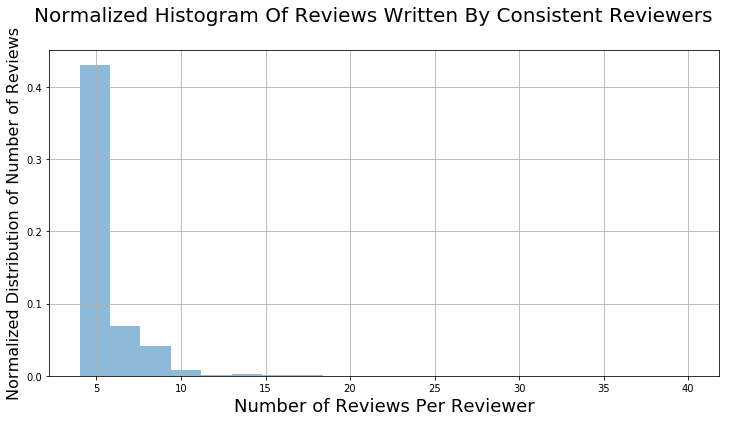

In [42]:
#isolate the consistent reviewer series

rid_count = re_fashion.groupby('reviewerID').reviewerID.count()
consistent_reviewers = rid_count[rid_count>3]

#plot histogram of normalized consistent review distribution

fig1 = plt.figure(figsize=(12,6))
fig1.suptitle('Normalized Histogram Of Reviews Written By Consistent Reviewers', fontsize=20)
ax = consistent_reviewers.hist(bins=20, alpha=0.5, density=True)
plt.xlabel('Number of Reviews Per Reviewer', fontsize=18)
plt.ylabel('Normalized Distribution of Number of Reviews', fontsize=16)

plt.show()

Out of 749233 unique reviewers, there are only 93913 reviewers that have logged more than one reviews.  <br>This shows that a lot of the reviews are written by one-time reviewers.  <br>  It is also apparent that out of consistent reviewers, the number of reviews written by consistent reviewers drop rapidly after about 5 reviews.  <br> Maximum number of reviews by a consistent reviewer in this dataset is 40.


**NOTE: we are inspecting a small subset of the review data (1 of 29 categories), so a reviewer who may show as one-time reviewer in this section may have reviewed other products in different categories.**

Column 'reviewerID' may be maintained if possible.

#### 1.2.1.5  Column 'asin'

Column 'asin' contains the Amazon Standard Identification Number (ASIN) that is assigned by Amazon and its partners used for product identification within their product catalog.  <br>
This is a 10 alphanumeric unique identifiers and for books, asin is the ISBN number.

This field is crucial in identifying the products in which the review is written for.

As seen above in re_fashion.info() , there are no null entries for this column.

In [15]:
#checking for null values

print('how many null entries: ',re_fashion.asin.isnull().sum())

how many null entries:  0


In [16]:
'''
Takes review dataset as input

Prints asin data characteristics:  
number of unique asin in dataset,  number of asin with a single review,
number of asin with two to four reviews, number of reviews with five or more reviews.

'''

def analyzeASIN(df):
    
    
    #check how many unique asin are present

    print('number of unique asin: ',len(df.asin.unique()))
    
    #create a groupby pandas series to isolate asin and their counts
    
    asin_count = df.groupby('asin').asin.count()
    
    #prints number of single reviewed asin
    
    print('number of single reviewed asin: ', asin_count[asin_count==1].sum())
    
    #print number of asin having between two to four reviews
    
    print('number of 2-4 reviewed asin: ', asin_count[asin_count.between(2,4)].count())
    
    #print number of asin having five or more reviews
    
    print('number of 5 or more reviewed asin: ', asin_count[asin_count>=5].count())

    

In [17]:
analyzeASIN(re_fashion)

number of unique asin:  186189
number of single reviewed asin:  99962
number of 2-4 reviewed asin:  56107
number of 5 or more reviewed asin:  30120


Numbers above show that over 50% of the reviews in this dataset is a single reviewed product. <br> Any single reviewed asin is a representation of one user's thought on the product so it may not give us the accurate image of how the product is actually received by public.

We may choose to remove the products with inadequate number of reviews to it. <br> Maximum number of reviews on an asin is 4384.

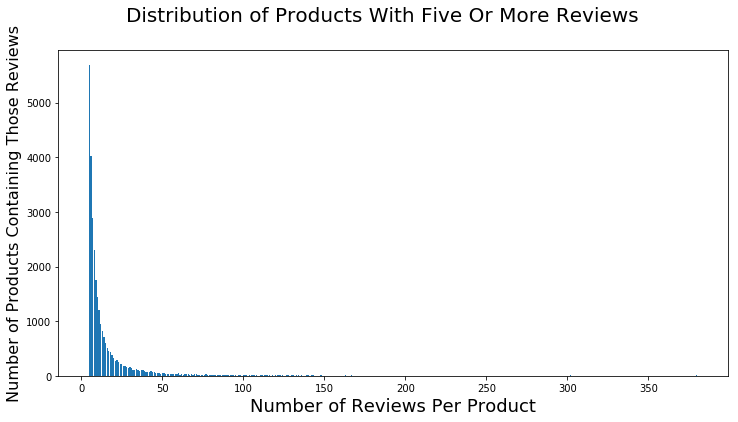

In [74]:
#isolate the asin counts

asin_count = re_fashion.groupby('asin').asin.count()

#removing actual asin identifier name from data as we are only interested in number of products per number of reviews

asin_value_count = asin_count.value_counts()
asin_df = asin_value_count.to_frame()
asin_over_five_df = df.loc[df.asin>4]

#plot distribution of number of reviews of products with five or more reviews

fig2 = plt.figure(figsize=(12,6))
fig2.suptitle('Distribution of Products With Five Or More Reviews', fontsize=20)
ax = plt.bar(df2.index[4:], df2['asin'][4:])
plt.xlabel('Number of Reviews Per Product', fontsize=18)
plt.ylabel('Number of Products Containing Those Reviews', fontsize=16)

plt.show()

The figure above shows the drop in number of products containing the amount of reviews specified in x axis.


Percentage of products containing reviews of five and over is 16.18%. <br> The remaining 83.82% of the product reviews are of products with 4 or less.  

Column 'asin' needs to be maintained.

#### 1.2.1.6 Column 'reviewerName'

Column 'reviewerName' contains the name of reviewer who wrote the review. <br> This field is of string datatype and can have any name that reviewer has set to be identified by.

This feature itself is a supplement to the reviewerID feature found above. <br> As we already that the reviewerID, this feature is not needed.

In [104]:
#checking datatype

print('feature datatype: ',type(re_fashion.reviewerName.loc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.reviewerName.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  92


Column 'reviewerName' is a good candidate for data trimming.

####  1.2.1.7 Column 'reviewText'

Column 'reviewText' contains the actual text review in string from the reviewer.

This data will be useful during sentiment analysis of the review and identifying keywords that describes the product. <br> Data from this feature can assist in give credit / weight to the overall ratings of the product.


In [89]:
#column reviewText examples
re_fashion.reviewText.head()

0                               Exactly what I needed.
1    I agree with the other review, the opening is ...
2    Love these... I am going to order another pack...
3                                  too tiny an opening
4                                                 Okay
Name: reviewText, dtype: object

In [103]:
#checking datatype

print('feature datatype: ',type(re_fashion.reviewText.loc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.reviewText.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  1233


This column only consists 1233 null entries out of 883636 data points. <br> This is good to see as we want as much as review texts as possible.

**NOTE: this is only a subset of the review dataset but it can serve as a good representation what we can expect to find in reviewText column of other categories of review dataset.**

Column 'reviewText' needs to be maintained.

#### 1.2.1.8 Column 'summary'

Column 'summary' contains summary of the reviewer's review in string format.  <br> This feature is very similar to the column reviewText above but is a concise version of it and can be thought of as supplement to reviewText and overall rating.

This data will be useful during sentiment analysis of the review and identifying keywords that describes the product. <br> Data from this feature can assist in give credit / weight to the overall ratings of the product.


In [93]:
#column reviewText examples
re_fashion.summary.head()

0                               perfect replacements!!
1    I agree with the other review, the opening is ...
2                                  My New 'Friends' !!
3                                            Two Stars
4                                          Three Stars
Name: summary, dtype: object

In [102]:
#checking datatype

print('feature datatype: ',type(re_fashion.summary.loc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.summary.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  533


This column only contains 533 null entries out of 883636 data points. <br>

**NOTE: this is only a subset of the review dataset but it can serve as a good representation what we can expect to find in summary column of other categories of review dataset.**

Column 'summary' may be maintained if possible.

#### 1.2.1.9 Column 'unixReviewTime'

Column 'unixReviewTime' contains the Unix timestamp of when the review was written. <br> As the products are generally unchanging, unless there is a need to analyze the data in time series, this field may not be useful.

As seen above in re_fashion.info() , there are no null entries for this column.

In [149]:
#examples of column style
re_fashion.loc[re_fashion.unixReviewTime.notnull()].unixReviewTime.head()

0    1413763200
1    1411862400
2    1408924800
3    1408838400
4    1406419200
Name: unixReviewTime, dtype: int64

In [101]:
#checking datatype

print('feature datatype: ',type(re_fashion.unixReviewTime.loc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.unixReviewTime.isnull().sum())

feature datatype:  <class 'numpy.int64'>
how many null entries:  0


Column 'unixReviewTime' is a good candidate for data trimming.

#### 1.2.1.10 Column 'vote'

Column 'vote' contains the numeric value of votes in datatype string that the review has received by other users. 

In [121]:
#checking datatype

print('feature datatype: ',type(re_fashion.loc[re_fashion.vote.notnull()].vote.iloc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.vote.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  803736


We are seeing very high ratio of vote data availability in the dataset.  <br> Less than 10% of the reviews contain votes at all. <br> The sheer number of null values make this feature not fit to be used.

**NOTE: this is only a subset of the review dataset but it can serve as a good representation what we can expect to find in vote column of other categories of review dataset.**

In [99]:
#Checking vote column
vote_notnull=set(map(int, re_fashion.loc[re_fashion.vote.notnull()].vote))

#print min and max
print('max: ',max(vote_notnull))
print('min: ',min(vote_notnull))

max:  966
min:  2


Column 'vote' is a good candidate for data trimming.  

#### 1.2.1.11 Column 'style'

Column 'style' contains data regarding the specific style of the product purchased by the reviewer. <br> 

In [147]:
#examples of column style
re_fashion.loc[re_fashion['style'].notnull()]['style'].head()

7     {'Color:': ' Black'}
8     {'Color:': ' Black'}
9     {'Color:': ' Black'}
10    {'Color:': ' Black'}
11    {'Color:': ' Black'}
Name: style, dtype: object

This field give additional details about the product that is reviewed.

In [129]:
#checking datatype

print('feature datatype: ',type(re_fashion.loc[re_fashion['style'].notnull()]['style'].iloc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion['style'].isnull().sum())

feature datatype:  <class 'dict'>
how many null entries:  579067


The above shows the style data is store in dictionary format.<br>
However, approximately 65% of style data are null making this field not fit to be used.

**NOTE: this is only a subset of the review dataset but it can serve as a good representation what we can expect to find in style column of other categories of review dataset.**



Column 'style' is a good candicate for data trimming.

#### 1.2.1.12 Column 'image'

Column 'image' contains links to image files uploaded by the reviewers to add further details to written reviews. <br> 


In [150]:
#examples of column image
re_fashion.loc[re_fashion.image.notnull()].image.head()

155    [https://images-na.ssl-images-amazon.com/image...
287    [https://images-na.ssl-images-amazon.com/image...
323    [https://images-na.ssl-images-amazon.com/image...
513    [https://images-na.ssl-images-amazon.com/image...
950    [https://images-na.ssl-images-amazon.com/image...
Name: image, dtype: object

The images are loaded in Amazon server: http://images-na.ssl-images-amazon.com/images/* .

In [136]:
#checking datatype

print('feature datatype: ',type(re_fashion.loc[re_fashion.image.notnull()].image.iloc[0]))
      
#checking for null values

print('how many null entries: ',re_fashion.image.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  854829


As we are not planning on analzying the images in this project, this field is not needed. <br>
Moreover, there are less than 5% availability for the image field making it unfit to be used.

**NOTE: this is only a subset of the review dataset but it can serve as a good representation what we can expect to find in vote column of other categories of review dataset.**

Column 'image' is a good candidate for data trimming.

### 1.2.2 Dataset 'review' Analysis Remarks

In [130]:
re_fashion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883636 entries, 0 to 883635
Data columns (total 12 columns):
overall           883636 non-null float64
verified          883636 non-null bool
reviewTime        883636 non-null object
reviewerID        883636 non-null object
asin              883636 non-null object
reviewerName      883544 non-null object
reviewText        882403 non-null object
summary           883103 non-null object
unixReviewTime    883636 non-null int64
vote              79900 non-null object
style             304569 non-null object
image             28807 non-null object
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 121.7+ MB


Out of the columns available in dataset 'review' listed above, the columns are categorized into three buckets:

* Needs To Be Maintained:    **overall , asin , reviewText**
* May Be Maintained If Possible:   **verfied , reviewerID , summary**
* Candidates For Data Trimming:  **reviewTime , reviewerName , unixReviewTime , vote , style , image**


As mentioned above, only the category, AMAZON_FASHION, has been imported for initial data exploration for review dataset. <br> The availability of data for each columns will be different depending on the category selected. <br> However, this initial exploration gives us good representation of what the full dataset will look like and the availability of data for columns in other categories.

The important feature identification will be relavent throughout all the other categories as well.

### 1.2.3 Dataset 'product' Analysis

In this section, we will go through all the columns available in the 'product' dataset for its viability in our project.<br> AMAZON_FASHION category was selected for alphabetical reason and will serve as an example dataset during exploration.

In [6]:
#As an example, we will import one of the datasets to check the data and build infrastructure.

pr_fashion = getDF('data/metadata/meta_AMAZON_FASHION.json.gz')

#### Category: re_fashion

In [7]:
pr_fashion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186637 entries, 0 to 186636
Data columns (total 15 columns):
title           186632 non-null object
image           132017 non-null object
brand           139957 non-null object
feature         123875 non-null object
rank            180222 non-null object
date            185001 non-null object
asin            186637 non-null object
description     15869 non-null object
price           17799 non-null object
also_view       11595 non-null object
also_buy        21642 non-null object
fit             4831 non-null object
details         885 non-null object
similar_item    317 non-null object
tech1           97 non-null object
dtypes: object(15)
memory usage: 22.8+ MB


Importing all of the 29 categories of product dataset and working with them is very costly for resources. <br> Therefore, we will go through initial data exploration per categories starting with pr_fashion.

#### 1.2.3.1 Column 'title'

Column 'title' contains the full product title that is shown within Amazon shops. 

In [145]:
#examples of column title
pr_fashion.title.head()

0    Slime Time Fall Fest [With CDROM and Collector...
1    XCC Qi promise new spider snake preparing men'...
2                   Magical Things I Really Do Do Too!
3                   Ashes to Ashes, Oranges to Oranges
4    Aether & Empire #1 - 2016 First Printing Comic...
Name: title, dtype: object

This field may not be needed during analysis or modelling but is needed in post-modelling output data formatting. <br> 

This is because we will mainly be working with the asin to identify the products. <br> However in the final output, we would need to provide to the users the actual title of the asin product as well.

For this reason, we will keep a separate copy of asin-to-title data that we can use at the end and leave it out of the modelling process.

In [143]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.title.notnull()].title.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.title.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  5


The product title is stored in string format.  <br> It is also shown that there are a few missing titles.  <br> These will need to be dealt during data clean up as we cannot have a product without a title.

Column 'title' needs to be maintained.

#### 1.2.3.2 Column 'image'

Similar to column 'image' in review dataset, this column contains links to images that showcases the product. <br> Unlike review dataset's image field, this field contains the official images uploaded by the seller.

In [155]:
#column image exampless
pr_fashion.image.head()

0    [https://images-na.ssl-images-amazon.com/image...
1    [https://images-na.ssl-images-amazon.com/image...
2    [https://images-na.ssl-images-amazon.com/image...
3    [https://images-na.ssl-images-amazon.com/image...
4    [https://images-na.ssl-images-amazon.com/image...
Name: image, dtype: object

The images are loaded in Amazon server: http://images-na.ssl-images-amazon.com/images/* .

In [157]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.image.notnull()].image.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.image.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  54620


As we are not planning on analyzing the images in this project, this field is not needed. 

**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in image column of other categories of product dataset.**

Column 'image' is a good candidate for data trimming.

#### 1.2.3.3  Column 'brand'

Column 'brand' contains the company brand that the product is marked by.

In [159]:
#column brand examples
pr_fashion[pr_fashion.brand.notnull()].brand.head()

0     Group Publishing (CO)
2         Christopher Manos
3    Flickerlamp Publishing
7                    Didala
8                 sevendayz
Name: brand, dtype: object

Similar to the title column, this field is also not needed during analysis and modelling. <br> However, this field will come in handy in the final output formatting by giving additional information about the product.

Thie field will also be added to the separate copy of asin-to-title data that can be used at the end.

In [160]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.brand.notnull()].brand.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.brand.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  46680


It is shown that this field is missing the brand data for about 25% of the dataset. <br>
Unlike the null values in title, missing brand data is not worrysome as this is addtional information.

Column 'brand' needs to be maintained.

#### 1.2.3.4  Column 'feature'

Column 'feature' contains information regarding product dimension and weight.

In [165]:
#column feature examples
print(pr_fashion[pr_fashion.feature.notnull()].feature.iloc[0])
print(pr_fashion[pr_fashion.feature.notnull()].feature.iloc[1])

['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds']
['Package Dimensions:\n                    \n8.5 x 5.5 x 0.4 inches', 'Shipping Weight:\n                    \n6.1 ounces']


In [183]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.feature.notnull()].feature.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.feature.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  62762


As we are not analyzing any dimension or weight data in this project, this field is not needed.

**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in feature column of other categories of product dataset.**

Column 'feature' is a good candidate for data trimming.

#### 1.2.3.5 Column 'rank'

Column 'rank' contains information regarding the rank of the product within different categories.

In [181]:
#column rank examples
pr_fashion['rank'].iloc[0]

'13,052,976inClothing,Shoesamp;Jewelry('

Data is alphanumeric characters stored in string format.  

This field may be useful in determining the popular products and serve as supplement to overall rank of the product. <br> If this field can be wrangled into some feature that we can use, but the rank categories does not seem to follow the traditional category format like how the dataset is categorized. <br>
If it is the case that these rank categories are difficult to manage, we will focus on using other features for our model.

In [185]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion["rank"].notnull()]["rank"].iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion["rank"].isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  6415


Column 'rank' may be maintained if possible.

#### 1.2.3.6 Column 'date'

In [194]:
#column date examples
pr_fashion["date"].iloc[100:200:10]

100       5 star5 star (0%)
110       5 star5 star (0%)
120                  5 star
130       Amazon Collection
140                  5 star
150                  5 star
160    101858-1174067964699
170                  5 star
180             Ross-Simons
190       Amazon Collection
Name: date, dtype: object

Unlike the expectation, this field does not seem to contain the date information but various text fields that cannot be categorized into a theme. <br> Possibly, this field contains the secondary information that did not make it into brand names or product names.  

In [197]:
#checking some values under date field

pr_fashion.date.unique()[:50]

array(['8.70 inches', '5 star', 'fishhook', '5 star5 star (0%)', nan,
       'T 53952 9J', 'GoldenMine.com Jewelry', 'Avelor Collection',
       'Amazon Collection', 'Amazon.com Collection',
       '101858-1174067964699', 'Szul', 'Ross-Simons', 'Timex', 'Gemworks',
       'NIKE', 'Swiss Army', 'Littman Jewelers', 'G95216L', 'Fossil',
       'Seiko', 'WT0002501', '15-1402-01', 'Skagen',
       'Universal Electronics', 'TechnoMarine', 'MU0943', 'TZNIWT0009001',
       'Swatch', 'Avalon-A-1405', 'Silver Insanity', 'Overstock Jeweler',
       '24028', '925 Sterling', '1 inches', 'Kenneth Cole',
       'Sabrina Silver', 'CL5008', 'Silver Forest', 'WT0001-411',
       'WT0002-411', 'WT0009-507', 'CoolStyles.com', 'ESQ',
       'American Pearl', 'MU0942', 'DC Studios', 'Religious',
       'Gem Avenue', '2 inches'], dtype=object)

Looking at some of these unique values of date field, we can see that this field indeed does not contain any data regarding dates. <br> Due to the field not being clear on its purpose, this field is not fit to be used in the next steps.

Column 'date' is a good candidate for data trimming.

#### 1.2.3.7 Column 'asin'

Column 'asin' contains the Amazon Standard Identification Number (ASIN) that is assigned by Amazon and its partners used for product identification within their product catalog.  <br>
This is a 10 alphanumeric unique identifiers and for books, asin is the ISBN number.

This field is crucial in identifying the products in which the review is written for.

As seen above in pr_fashion.info() , there are no null entries for this column.

In [8]:
#checking for null values

print('how many null entries: ',pr_fashion.asin.isnull().sum())

how many null entries:  0


In [12]:
'''
Takes product dataset as input

Prints asin data characteristics:  
number of unique asin in dataset, number of duplicated asin, 
different numbers of duplicate amounts in the duplicate asin

'''

def analyzeProductASIN(df):
    
    
    #check how many unique asin are present

    print('number of unique asin: ',len(df.asin.unique()))
    
    #create a groupby pandas series to isolate asin and their counts
    
    asin_count = df.groupby('asin').asin.count()
    
    #prints number of duplicated asin
    
    print('number of duplicated asin: ', asin_count[asin_count>1].count())
    
    
    asin_duplicated = asin_count[asin_count>1]
    
    #different numbers of duplicate amounts in the duplicate asin
    
    print('different numbers of duplicate amounts in the duplicate asin: ', asin_duplicated.unique())

analyzeProductASIN(pr_fashion)

number of unique asin:  186194
number of duplicated asin:  443
different numbers of duplicate amounts in the duplicate asin:  [2]


Most of the asin in the list makes sense but there are a few duplicated entries as well. <br>

In [46]:
#find out the asin of duplicated entries

asin_count = pr_fashion.groupby('asin').asin.count()
asin_duplicated = list(asin_count[asin_count>1].index)

#print the duplicated asin for analysis

pr_fashion.loc[pr_fashion.asin.isin(asin_duplicated)].head()


,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
18,Shimmer Anne Shine Clip On Costume/Halloween C...,[https://images-na.ssl-images-amazon.com/image...,Shimmer Anne Shine,[Shimmer Anne Shine Clip On Costume/Halloween ...,"468,314inClothing,ShoesJewelry(",5 star,B00004T3SN,"[A fun addition to any costume party, play, or...",$6.99,"[B00Q5RRK78, B00RN3JILE, B00PMUTNOM, B01KA5PTY...",[B01KA5PTYG],NaN,NaN,NaN,NaN
19,SpongeBob Squarepants Comforter - Twin,NaN,SpongeBob SquarePants,[Package Dimensions:\n \n21...,"23,888,557inClothing,ShoesJewelry(",5 star,B00005OTJ8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Cedar Tie Hanger,NaN,NaN,NaN,"20,806,337inClothing,ShoesJewelry(",5 star,B00006MVYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Perlina Morgan Collection Wallet on a String (...,NaN,PERLINA,NaN,"26,245,347inClothing,ShoesJewelry(",5 star,B000072X6P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,Trager Metropolitan,[https://images-na.ssl-images-amazon.com/image...,Trager,NaN,NaN,5 star5 star (0%),B000072WZM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It does not look like there are any special cases for these duplicated ASIN.


Out of 186194 unique ASIN in this dataframe, 186619 ASINs start with 'B' for this category so it is not that ASIN starting with 'B' are having duplicate issues. <br>
We will need to remove these duplicated entries later on.

Column 'asin' needs to be maintained.

#### 1.2.3.8 Column 'description'

Column 'description' contains string in lists data information regarding description of the products.

In [20]:
#column description examples

pr_fashion.loc[pr_fashion.description.notnull()==1].description.head()

2     [For the professional or amateur magician.  Ro...
11    [Educating the next generation in the responsi...
12    [Envirosax Greengrocer - a range of plain colo...
17    [When you pull out your extra large carbon fib...
18    [A fun addition to any costume party, play, or...
Name: description, dtype: object

In [21]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.description.notnull()].description.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.description.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  170768


This field contains too many null values for this to be used in this project.

**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in description column of other categories of product dataset.**

Column 'description' is a good candidate for data trimming.

#### 1.2.3.9 Column 'price'

Column 'price' contains the price information of the product.

In [23]:
#column price examples
print(pr_fashion.loc[pr_fashion.price.notnull()==1].price.head())

4       $4.50
17     $14.99
18      $6.99
69     $16.95
115     $9.02
Name: price, dtype: object


In [24]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.price.notnull()].price.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.price.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  168838


Similar to the column description above, this field also contains useful information. <br>
However, the scope of this project does not cover the costs of the products. <br>
Also, this field has about 10% data availability which makes it not fit to be used.

**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in description column of other categories of product dataset.**


Column 'price' is a good candidate for data trimming.

#### 1.2.3.10 Column 'also_view'

Column 'also_view' contains list of different ASINs that is associated with the record. <br> These linked products would be the products that are closely related or searched together by users.

In [27]:
#column also_view examples
print(pr_fashion.loc[pr_fashion.also_view.notnull()==1].also_view.head())

17    [B07CQ3KY5B, B014TEOG3O, B078429G6J, B01FRG9Z7...
18    [B00Q5RRK78, B00RN3JILE, B00PMUTNOM, B01KA5PTY...
69    [B07C9V84JD, B01J6JE05G, B07J11WZ5Y, B07JJQFHS...
81                                         [B00CF0S9TW]
82                             [B00CF0V95I, B07F5RDSYZ]
Name: also_view, dtype: object


These data may help in clustering relavant products together. 

However, data availability for this field is also very weak : less than 10%.  <br> If there are less than 10% of data available to be used, it will be considered a better choice to remove this field.

In [28]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.also_view.notnull()].also_view.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.also_view.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  175042



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in also_view column of other categories of product dataset.**

Column 'also_view' may be maintained if possible.

#### 1.2.3.11 Column 'also_buy'

Column 'also_buy', similar to 'also_view' above, contains list of different ASINs that is associated with the record. <br> These linked products would be the products that are closely related and bought together by users.

In [29]:
#column also_buy examples
pr_fashion.loc[pr_fashion.also_buy.notnull()==1].also_buy.head()

18                                          [B01KA5PTYG]
69     [B07C9V84JD, B01J6JE05G, B07JJQFHS5, B003EGITU...
89                                          [B00C7P5HKE]
446    [B07BMF139V, B0018NFT5E, B00Y8DE9ES, B001AH4NY...
461                                         [B01KA5PTYG]
Name: also_buy, dtype: object

These data may help in clustering relavant products together. 

However, data availability for this field is also very weak : little over 10%.  <br> If there are 10% of data available to be used, it will be considered a better choice to remove this field.

In [30]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.also_buy.notnull()].also_buy.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.also_buy.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  164995



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in also_buy column of other categories of product dataset.**

Column 'also_buy' may be maintained if possible.

#### 1.2.3.12 Column 'fit'

Column 'fit' contains information regarding products' variation and fits. <br> The values in the field seem to be html/css language attempting to visualize the product.

In [36]:
#column fit examples
pr_fashion.loc[pr_fashion.fit.notnull()==1].fit.head()

69      class="a-normal a-align-center a-spacing-smal...
118     class="a-normal a-align-center a-spacing-smal...
433     class="a-normal a-align-center a-spacing-smal...
446     class="a-normal a-align-center a-spacing-smal...
512     class="a-normal a-align-center a-spacing-smal...
Name: fit, dtype: object

During the scope of this project, we are not working with any descriptive features like dimensions, prices, description and fit. <br>
Moreover in this example, we are seeing only 4831 data points available from 186637 records which does not allow us to utilize this field.

In [37]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.fit.notnull()].fit.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.fit.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  181806



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in fit column of other categories of product dataset.**

Column 'fit' is a good candidate for data trimming.

#### 1.2.3.13 Column 'details'

Column 'details' contains additional information regarding the products. <br>
Very similar to the column 'fit' above, this field contains html scripts that shows various details like different colors, links to product details, reviews and etc.

In [40]:
#column details examples
pr_fashion.loc[pr_fashion.details.notnull()==1].details.head()

377     \n      <div class="content">\n\n\n\n\n\n\n<ul...
424     \n      <div class="content">\n\n\n\n\n\n\n<ul...
820     \n      <div class="content">\n\n\n\n\n\n\n<ul...
867     \n      <div class="content">\n\n\n\n\n\n\n<ul...
1012    \n      <div class="content">\n\n\n\n\n\n\n<ul...
Name: details, dtype: object

During the scope of this project, we are not working with any descriptive features like dimensions, prices, description and details. <br>
Moreover in this example, we are seeing only 885 data points available from 186637 records which does not allow us to utilize this field.

In [41]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.details.notnull()].details.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.details.isnull().sum())

feature datatype:  <class 'str'>
how many null entries:  185752



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in details column of other categories of product dataset.**

Column 'details' is a good candidate for data trimming.

#### 1.2.3.14 Column 'similar_item'

Column 'similar_item' holds information regarding items that are similar to the product mentioned in the record. <br> This field is similar to the also_view and also_buy but this field is focused on showing the similar items rather than things that are usually bought together.

In [42]:
#column similar_item examples
pr_fashion.loc[pr_fashion.similar_item.notnull()==1].similar_item.head()

2686    [{'asin': '', 'href': '', 'name': 'Comfy Mouse...
5758    [{'asin': '', 'href': '', 'name': 'Solid Ties ...
7576    [{'asin': '', 'href': '', 'name': 'Aegean Mens...
8029    [{'asin': '', 'href': '', 'name': 'Deluxe Mesh...
8719    [{'asin': '', 'href': '', 'name': 'CZ Pave Lib...
Name: similar_item, dtype: object

Although this information could be used, similar items' ASIN is rarely seen. <br> This makes things very difficult as we would need to search the product name to see if there is a hit on our list of ASIN.

Moreover, this field only contains information for 317 records out of 186637 making this unfit for use.

In [43]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.similar_item.notnull()].similar_item.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.similar_item.isnull().sum())

feature datatype:  <class 'list'>
how many null entries:  186320



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in similar_item column of other categories of product dataset.**

Column 'similar_item' is a good candidate for data trimming.

#### 1.2.3.15 Column 'tech1'

Column 'tech1' consists of additional technical details about the products. <br> This field can include dimensions, weight, brand names and etc.

In [44]:
#column tech1 examples
pr_fashion.loc[pr_fashion.tech1.notnull()==1].tech1.head()

3707    {'Brand Name': 'Bosca', 'Item Weight': '6.4 ou...
3911    {'Item Weight': '1 pounds', 'Product Dimension...
4380    {'Item Weight': '2.4 ounces', 'Product Dimensi...
4530     {'Product Dimensions': '9 x 11.8 x 17.8 inches'}
7506    {'Brand Name': 'LeDonne', 'Item Weight': '2.5 ...
Name: tech1, dtype: object

During the scope of this project, we are not working with any descriptive features like dimensions, prices, description and details. <br>
Tech1 field is also a part of descriptive features. <br>
Moreover in this example, we are seeing only 97 data points available from 186637 records which does not allow us to utilize this field.

In [45]:
#checking datatype

print('feature datatype: ',type(pr_fashion.loc[pr_fashion.tech1.notnull()].tech1.iloc[0]))
      
#checking for null values

print('how many null entries: ',pr_fashion.tech1.isnull().sum())

feature datatype:  <class 'dict'>
how many null entries:  186540



**NOTE: this is only a subset of the product dataset but it can serve as a good representation what we can expect to find in tech1 column of other categories of product dataset.**

Column 'tech1' is a good candidate for data trimming.

#### 1.2.3.16 Column 'main_cat'

In [4]:
#datasets imported.

pr_MTV = getDF('data/metadata/meta_Movies_and_TV.json.gz')

Some product datasets also contain field called main_cat which contains information about categories the media is in.

In [5]:
#column main_cat examples
pr_MTV.loc[pr_MTV.main_cat.notnull()==1].main_cat.head()

0    Movies & TV
1    Movies & TV
2    Movies & TV
3    Movies & TV
4    Movies & TV
Name: main_cat, dtype: object

In [6]:
#different types of categories
print(pr_MTV.main_cat.unique())

['Movies & TV' 'Books' 'All Beauty' nan 'Toys & Games' 'Sports & Outdoors'
 'Industrial & Scientific' 'All Electronics' 'Arts, Crafts & Sewing'
 'Health & Personal Care' 'Amazon Home' 'Tools & Home Improvement'
 'Cell Phones & Accessories' 'Pet Supplies' 'Baby' 'Camera & Photo'
 'Video Games' 'Home Audio & Theater' 'Office Products'
 'Musical Instruments' 'Grocery']


This field will be useful when it comes to identifying and grouping differnt products together.

Column 'main_cat' may be maintained if possible.

#### 1.2.3.17 Column 'category'

Similar to above, we also have category field available for some media related products where it provides details as to which group media belongs.

In [14]:
#column category examples
pr_MTV.loc[pr_MTV.category.notnull()==1].category[:1000:50]

0                                  [Movies & TV, Movies]
50     [Movies & TV, Musicals & Performing Arts, Musi...
100                                [Movies & TV, Movies]
150    [Movies & TV, Musicals & Performing Arts, Musi...
200    [Movies & TV, Genre for Featured Categories, M...
250    [Movies & TV, Studio Specials, Sony Pictures H...
300    [Movies & TV, Studio Specials, Sony Pictures H...
350    [Movies & TV, Studio Specials, Warner Home Vid...
400    [Movies & TV, Studio Specials, Warner Home Vid...
450    [Movies & TV, Studio Specials, Universal Studi...
500    [Movies & TV, Genre for Featured Categories, D...
550    [Movies & TV, Characters & Series, Mary-Kate &...
600    [Movies & TV, Studio Specials, Warner Home Vid...
650    [Movies & TV, Paramount Home Entertainment, Dr...
700    [Movies & TV, Studio Specials, 20th Century Fo...
750    [Movies & TV, Studio Specials, Sony Pictures H...
800                [Movies & TV, Christian Video, Bible]
850    [Movies & TV, Musicals &

Since we already have the main category field defined and this field provides additional data which we don't need, this field can be considered redundant.

Column 'category' is a good candidate for data trimming.

### 1.2.4 Dataset 'product' Analysis Remarks

In [180]:
pr_fashion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186637 entries, 0 to 186636
Data columns (total 15 columns):
title           186632 non-null object
image           132017 non-null object
brand           139957 non-null object
feature         123875 non-null object
rank            180222 non-null object
date            185001 non-null object
asin            186637 non-null object
description     15869 non-null object
price           17799 non-null object
also_view       11595 non-null object
also_buy        21642 non-null object
fit             4831 non-null object
details         885 non-null object
similar_item    317 non-null object
tech1           97 non-null object
dtypes: object(15)
memory usage: 27.8+ MB


Out of the columns available in dataset 'product' listed above, the columns are categorized into three buckets:

* Needs To Be Maintained:    **title , asin , brand**
* May Be Maintained If Possible:   **rank , also_view , also_buy, main_cat**
* Candidates For Data Trimming:  **image , feature , date , description , price , fit , details , similar_item , tech1, category**


As mentioned above, only the category, AMAZON_FASHION, has been imported for initial data exploration for product dataset. <br> The availability of data for each columns will be different depending on the category selected. <br> However, this initial exploration gives us good representation of what the full dataset will look like and the availability of data for columns in other categories.

The important feature identification will be relavent throughout all the other categories as well.